In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


2023-05-06 23:02:07.333630: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 23:02:07.336070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 23:02:07.379228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 23:02:07.380080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 23:02:09.601754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
df = pd.read_csv('Data/Train/4105819v2474763.csv', index_col=0)
df

,ltp odds,r1 spread,r1 pup,r2 spread,r2 pup,enhanced_markov,r1_0,r1_1,r1_2,r1_3,r2_0,r2_1,r2_2,r2_3
2018-07-11 16:36:40,0.582332,0.008959,0.255166,0.018627,0.242267,0.507162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-11 16:36:45,0.582423,0.008959,0.255166,0.018627,0.242267,0.507162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-11 16:36:50,0.582515,0.008959,0.255166,0.018627,0.242267,0.507162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-11 16:36:55,0.582606,0.008959,0.255166,0.018627,0.242267,0.507162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2018-07-11 16:37:00,0.582697,0.008959,0.255166,0.018627,0.242267,0.507162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-11 19:32:52,0.000000,1.624489,0.267253,0.037379,0.658020,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2018-07-11 19:32:55,0.000000,1.624489,0.267253,0.037379,0.658020,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2018-07-11 19:32:57,0.000000,1.624489,0.267253,0.037379,0.658020,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2018-07-11 19:33:00,0.000000,1.624489,0.267253,0.037379,0.658020,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [4]:
data = df.to_numpy()
data

array([[0.5823319 , 0.00895867, 0.25516555, ..., 0.        , 0.        ,
        1.        ],
       [0.58242327, 0.00895867, 0.25516555, ..., 0.        , 0.        ,
        1.        ],
       [0.58251465, 0.00895867, 0.25516555, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 1.62448857, 0.26725326, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.62448857, 0.26725326, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.62448857, 0.26725326, ..., 0.        , 0.        ,
        0.        ]])

In [5]:
train, test = train_test_split(data, test_size=0.4, shuffle=False)
train_x, train_y = seq2seq_model.truncate_data(data, 60 * 3, 60)
# train = data[: 60 * 8, :]
# test = data[60 * 8 :, :]
print(test.shape, train.shape)
print(train_x[2,:,0])
print(train_y[2,:,0])

(876, 14) (1314, 14)
[0.58251465 0.58260602 0.58269739 0.58278877 0.58288014 0.5834663
 0.58414671 0.58482712 0.58496561 0.58505699 0.58514836 0.58523973
 0.58533111 0.58542248 0.58551385 0.58560522 0.5856966  0.58578431
 0.58578431 0.58589716 0.58606311 0.58622907 0.58639502 0.58656097
 0.58672692 0.58689288 0.58705883 0.58722478 0.58739073 0.588024
 0.58899567 0.59026656 0.59136516 0.59079734 0.59022952 0.59029274
 0.59071485 0.59128104 0.59184723 0.5924431  0.59320997 0.59367265
 0.59422444 0.59638017 0.59684285 0.59730554 0.59776822 0.5982309
 0.59908912 0.60034286 0.60142258 0.60188526 0.60265219 0.60385699
 0.6046176  0.6046176  0.6046176  0.6046176  0.6046176  0.6046176
 0.6046176  0.6046176  0.6046176  0.6046176  0.6046176  0.6046176
 0.6046176  0.6046176  0.6046176  0.6046176  0.6046176  0.6046176
 0.6046176  0.6046176  0.6046176  0.60461262 0.60436323 0.60386567
 0.60335777 0.60284987 0.60234197 0.60183407 0.60132617 0.60120482
 0.60120482 0.60120482 0.60120482 0.60120482 0.6

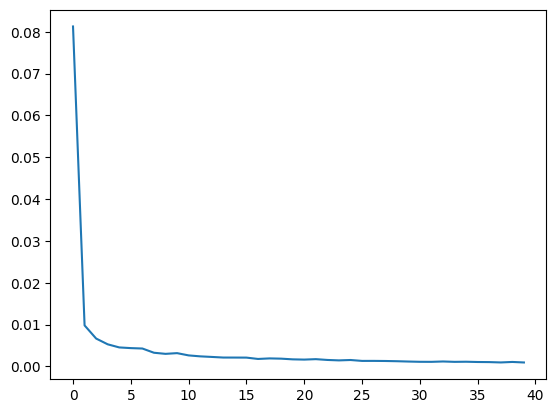

In [6]:
hist = pd.read_csv('train_hist.csv')
plt.plot(hist['mse'])

In [7]:
model = load_model("seq2seq_model_single")
model.summary()

2023-05-06 23:02:14.056145: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-06 23:02:14.370739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-05-06 23:02:14.370855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMEN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 200)           168800    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 500,160
Trainable params: 500,160
Non-trainable params: 0


2023-05-06 23:02:16.045055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:02:16.046614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:02:16.047588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

_________________________________________________________________


In [8]:
# score, scores, actual, predicted = seq2seq_model.evaluate_model(model, train, test, 3, 60, features=range(8), features_out_num=1, initial_epochs=30, epochs=2, batches_to_train=1)
test_x, test_y = seq2seq_model.truncate_single_step(test, 36, features_in=[0,5,6,7,8,9,10,11,12,13], features_out=[0,5,6,7,8,9,10,11,12,13])
print(test_x.shape, test_y.shape)
results = model.evaluate(test_x, test_y)
preds = model.predict(test_x)

(840, 36, 10) (840, 10)


2023-05-06 23:02:16.609979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:02:16.612228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:02:16.613207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 2s 31ms/step - loss: 0.0011 - mae: 0.0084 - mse: 0.0011 


2023-05-06 23:02:18.242782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 23:02:18.243915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 23:02:18.245142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 1s 31ms/step


RMSE:  0.033249204230712634
MAE:  0.008376038633286953


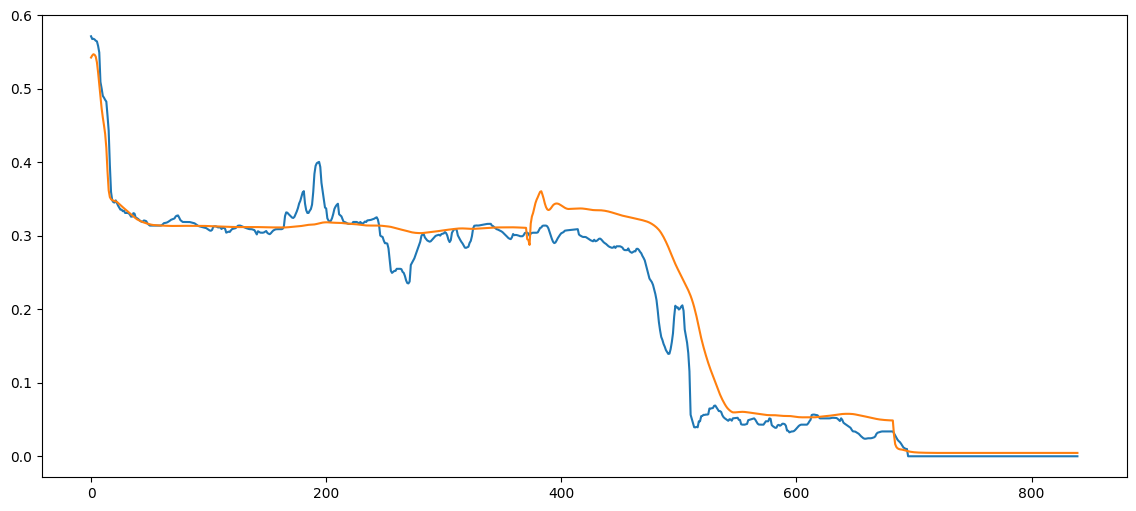

In [9]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
plt.plot(preds[:,0])
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [10]:
forecasts = []
i = 0
while i * 36 < test_x.shape[0]:
    pred_x = test_x[36 * i, :, :]
    pred_x = pred_x.reshape((1, 36, pred_x.shape[1]))
    y_future = []
    for k in range(36):
        pred_y = model.predict(pred_x)
        y_future.append(pred_y)
        pred_x = np.append(pred_x[:, 1:, :], pred_y.reshape(1, 1, 10), axis=1)
    forecasts.append(y_future)
    i += 1
    

1/1 [==============================] - 0s 40ms/step


RMSE:  0.0011055095819756389
MAE:  0.008376038633286953
(24, 36, 1, 10)
(864,)
     Predictions
0       0.542534
1       0.545470
2       0.547032
3       0.546473
4       0.544032
..           ...
859     0.004583
860     0.004583
861     0.004583
862     0.004582
863     0.004582

[864 rows x 1 columns]


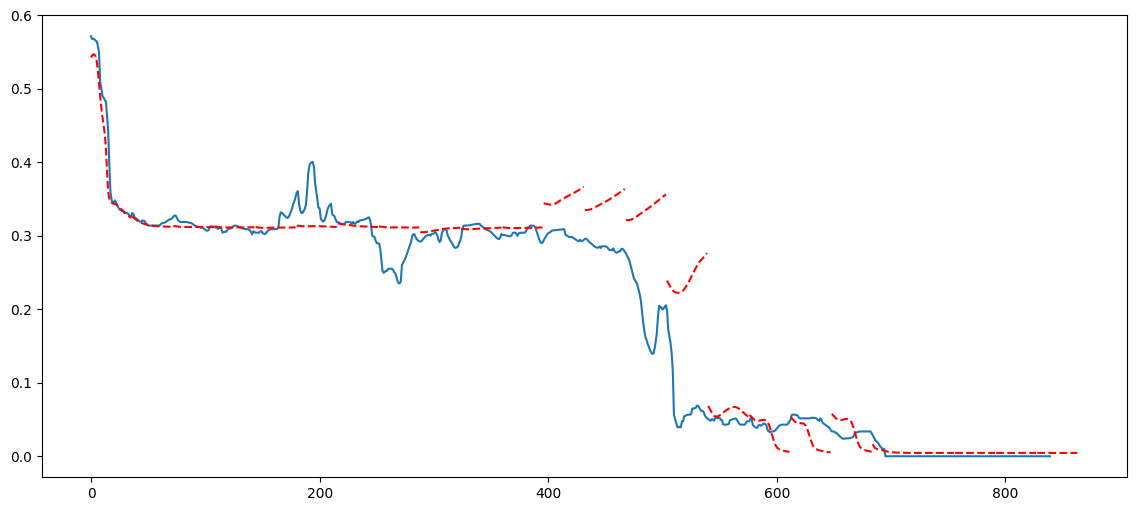

In [16]:
print('RMSE: ', results[0])
print('MAE: ', results[1])
forecasts_arr = np.array(forecasts)
forecasts_flat = forecasts_arr[:, :, 0, 0].flatten()
print(forecasts_arr.shape)
print(forecasts_flat.shape)
df_preds = pd.DataFrame({'Predictions': forecasts_flat})
print(df_preds)
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
i = 0
idx = 0

while idx + 36 <= test_x.shape[0]:
     idx = 36 * i
     s_pred = df_preds.iloc[idx:idx + 36]
     plt.plot(s_pred, '--', color='red')
     i += 1

In [12]:
# print('RMSE: ', score)
# actual_odds = actual.reshape((actual.shape[0]*actual.shape[1]))
# predicted_odds = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
# df_pred = pd.DataFrame({'pred':predicted_odds})
# plt.figure(figsize=(14,6))
# plt.plot(actual_odds)
# for i in range(predicted.shape[0]):
#     idx = 60 * i
#     s_pred = df_pred.iloc[idx:idx + 60]
#     plt.plot(s_pred, '--', color='red')